In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!ls /content | grep npy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("[INFO] Libraries loaded successfully.")

[INFO] Libraries loaded successfully.


In [10]:
from google.colab import drive
drive.mount('/content/drive')

LOAD_DIR = "/content/drive/MyDrive/car_damage_detection"

trainX = np.load(f"{LOAD_DIR}/trainX.npy")
trainY = np.load(f"{LOAD_DIR}/trainY.npy")
testX  = np.load(f"{LOAD_DIR}/testX.npy")
testY  = np.load(f"{LOAD_DIR}/testY.npy")

print("trainX:", trainX.shape)
print("trainY:", trainY.shape)
print("testX :", testX.shape)
print("testY :", testY.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
trainX: (1840, 224, 224, 3)
trainY: (1840, 2)
testX : (460, 224, 224, 3)
testY : (460, 2)


In [11]:
# --- Define Hyperparameters + Augmentation ---

# --- Hyperparameters ---
INIT_LR = 1e-5     # learning rate
EPOCHS = 30        # fewer epochs at first (increase later if needed)
BS = 32            # batch size

# --- Data Augmentation ---
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

print("[INFO] Data augmentation generator ready.")

[INFO] Data augmentation generator ready.


In [12]:
# --- Load base MobileNetV2 model ---
baseModel = MobileNetV2(weights="imagenet",
                        include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

# --- Add custom classification head ---
headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# --- Combine base & head ---
model = Model(inputs=baseModel.input, outputs=headModel)

# --- Freeze base layers (train only top) ---
for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] Model created successfully.")
model.summary()

/tmp/ipython-input-882630073.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet",


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[INFO] Model created successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# --- Compile model ---
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] Model compiled.")

[INFO] Model compiled.


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [14]:
# --- Define callbacks ---
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_mobilenetv2.h5", monitor="val_accuracy", save_best_only=True)

# --- Train ---
print("[INFO] Training started...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)

print("[INFO] Training completed.")

[INFO] Training started...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5358 - loss: 2.8840

57/57 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.5357 - loss: 2.8825 - val_accuracy: 0.6326 - val_loss: 0.9690
Epoch 2/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - accuracy: 0.5000 - loss: 3.7460

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.5000 - loss: 3.7460 - val_accuracy: 0.6391 - val_loss: 0.9645
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5351 - loss: 2.4711

57/57 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.5353 - loss: 2.4685 - val_accuracy: 0.7196 - val_loss: 0.7981
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 332ms/step - accuracy: 0.7812 - loss: 0.8863 - val_accuracy: 0.7196 - val_loss: 0.7967
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5724 - loss: 1.9352

57/57 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.5729 - loss: 1.9335 - val_accuracy: 0.7370 - val_loss: 0.7645
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 331ms/step - accuracy: 0.6562 - loss: 1.5396 - val_accuracy: 0.7370 - val_loss: 0.7631
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6202 - loss: 1.7689

57/57 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.6204 - loss: 1.7660 - val_accuracy: 0.7413 - val_loss: 0.7429
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 330ms/step - accuracy: 0.7812 - loss: 0.8132 - val_accuracy: 0.7413 - val_loss: 0.7452
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6590 - loss: 1.3645

57/57 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.6590 - loss: 1.3640 - val_accuracy: 0.7739 - val_loss: 0.6361
Epoch 10/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 349ms/step - accuracy: 0.6562 - loss: 1.0853 - val_accuracy: 0.7739 - val_loss: 0.6388
Epoch 11/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6654 - loss: 1.2190

57/57 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.6654 - loss: 1.2200 - val_accuracy: 0.7761 - val_loss: 0.6708
Epoch 12/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 366ms/step - accuracy: 0.5312 - loss: 1.7698 - val_accuracy: 0.7761 - val_loss: 0.6688
Epoch 13/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6874 - loss: 1.1005

57/57 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.6873 - loss: 1.1006 - val_accuracy: 0.7978 - val_loss: 0.5968
Epoch 14/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 331ms/step - accuracy: 0.6875 - loss: 0.8463 - val_accuracy: 0.7978 - val_loss: 0.5955
Epoch 15/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.7353 - loss: 0.8798 - val_accuracy: 0.7957 - val_loss: 0.5905
Epoch 16/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.6562 - loss: 0.8352 - val_accuracy: 0.7957 - val_loss: 0.5891
Epoch 17/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7168 - loss: 0.9592

57/57 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7169 - loss: 0.9586 - val_accuracy: 0.8065 - val_loss: 0.5334
Epoch 18/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 366ms/step - accuracy: 0.6875 - loss: 0.9748 - val_accuracy: 0.8065 - val_loss: 0.5342
Epoch 19/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7330 - loss: 0.8431 - val_accuracy: 0.8065 - val_loss: 0.5478
Epoch 20/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 330ms/step - accuracy: 0.6875 - loss: 1.1342 - val_accuracy: 0.8065 - val_loss: 0.5486
Epoch 21/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7287 - loss: 0.8426

57/57 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7286 - loss: 0.8423 - val_accuracy: 0.8109 - val_loss: 0.5191
Epoch 22/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 334ms/step - accuracy: 0.7812 - loss: 0.6611 - val_accuracy: 0.8087 - val_loss: 0.5207
Epoch 23/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7231 - loss: 0.7797

57/57 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7234 - loss: 0.7788 - val_accuracy: 0.8174 - val_loss: 0.4905
Epoch 24/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 366ms/step - accuracy: 0.7812 - loss: 0.8326 - val_accuracy: 0.8174 - val_loss: 0.4906
Epoch 25/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7554 - loss: 0.7449

57/57 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7553 - loss: 0.7447 - val_accuracy: 0.8196 - val_loss: 0.4604
Epoch 26/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 366ms/step - accuracy: 0.7812 - loss: 0.7135 - val_accuracy: 0.8174 - val_loss: 0.4609
Epoch 27/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.7652 - loss: 0.6172 - val_accuracy: 0.8152 - val_loss: 0.4595
Epoch 28/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.7188 - loss: 0.5532 - val_accuracy: 0.8196 - val_loss: 0.4579
Epoch 29/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7733 - loss: 0.6153 - val_accuracy: 0.8174 - val_loss: 0.4626
Epoch 30/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 366ms/step - accuracy: 0.6875 - loss: 1.0762 - val_accuracy: 0.8152 - val_loss: 0.4628
[INFO] Training completed.


In [21]:
from tensorflow.keras.optimizers import Adam

print("[INFO] Unfreezing some MobileNetV2 layers for fine‑tuning...")

# Unfreeze the last 20 layers of the base model
for layer in baseModel.layers[-20:]:
    layer.trainable = True

# Re‑compile with a smaller learning rate
opt_finetune = Adam(learning_rate=1e-6)

model.compile(loss="categorical_crossentropy", optimizer=opt_finetune, metrics=["accuracy"])

print("[INFO] Recompiled model with trainable base layers and lower LR.")

# class weights to emphasize damaged cars
class_weight = {0: 1.2, 1: 1.0}

# Continue training (fine‑tuning)
EPOCHS_FINETUNE = 10  # start with 5–10 extra epochs
BS = 32

print("[INFO] Starting fine‑tuning...")

H_finetune = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    epochs=EPOCHS_FINETUNE,
    class_weight=class_weight,
    callbacks=[early_stop, checkpoint]
)

print("[INFO] Fine‑tuning completed!")

# Save your improved model


[INFO] Unfreezing some MobileNetV2 layers for fine‑tuning...
[INFO] Recompiled model with trainable base layers and lower LR.
[INFO] Starting fine‑tuning...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.6832 - loss: 0.9584 - val_accuracy: 0.8130 - val_loss: 0.4838
Epoch 2/10
 1/57 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.6875 - loss: 0.9508

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 367ms/step - accuracy: 0.6875 - loss: 0.9508 - val_accuracy: 0.8130 - val_loss: 0.4843
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.7042 - loss: 0.9252 - val_accuracy: 0.8043 - val_loss: 0.5017
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 339ms/step - accuracy: 0.6875 - loss: 0.9414 - val_accuracy: 0.8043 - val_loss: 0.5019
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6969 - loss: 0.9115 - val_accuracy: 0.8000 - val_loss: 0.5098
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 338ms/step - accuracy: 0.7500 - loss: 0.7342 - val_accuracy: 0.8000 - val_loss: 0.5099
[INFO] Fine‑tuning completed!
[INFO] Fine‑tuned model saved as MobileNet_Car_detection_FineTuned.keras


In [22]:
model.save("/content/drive/MyDrive/car_damage_detection/MobileNet_Car_detection_FineTuned.keras")
print("[INFO] Fine‑tuned model saved as MobileNet_Car_detection_FineTuned.keras")

[INFO] Fine‑tuned model saved as MobileNet_Car_detection_FineTuned.keras


[INFO] Evaluating model...
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
              precision    recall  f1-score   support

   00-damage       0.89      0.73      0.80       230
    01-whole       0.77      0.91      0.83       230

    accuracy                           0.82       460
   macro avg       0.83      0.82      0.82       460
weighted avg       0.83      0.82      0.82       460



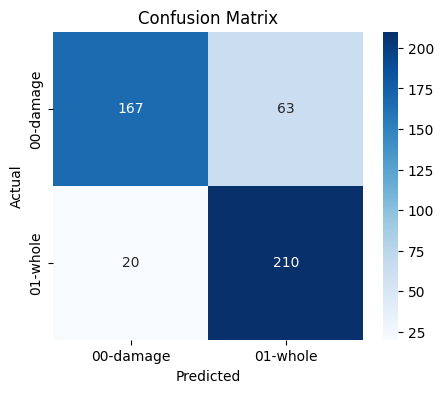

In [15]:
# --- Evaluate model ---
print("[INFO] Evaluating model...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
trueIdxs = np.argmax(testY, axis=1)

# --- Classification report ---
print(classification_report(trueIdxs, predIdxs, target_names=["00-damage", "01-whole"]))

# --- Confusion matrix ---
cm = confusion_matrix(trueIdxs, predIdxs)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["00-damage","01-whole"],
            yticklabels=["00-damage","01-whole"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

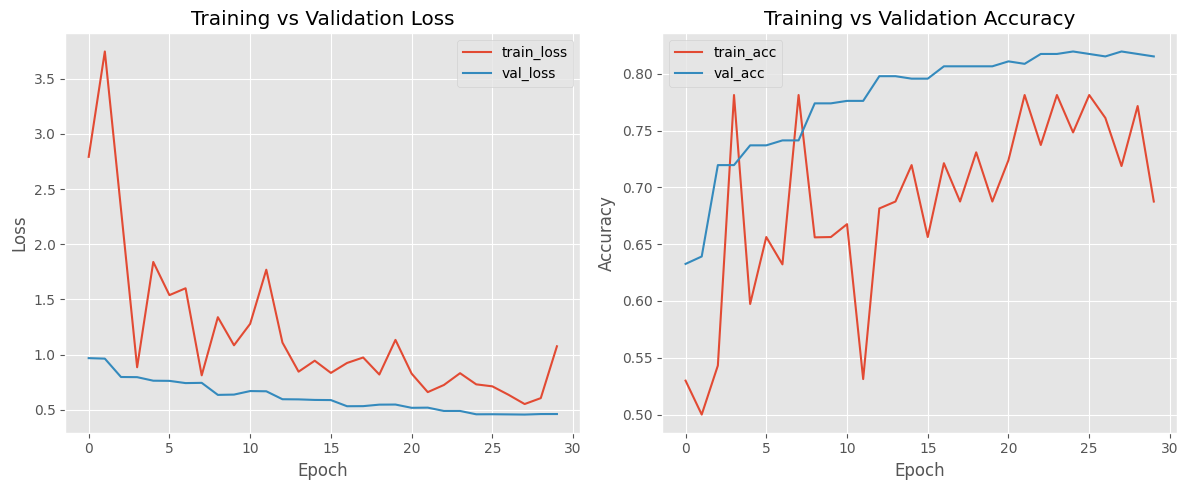

In [16]:
# --- Plot accuracy/loss curves ---
N = len(H.history["loss"])
plt.style.use("ggplot")
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# --- Save trained model ---
model.save("MobileNet_Car_detection_Final.h5")
print("[INFO] Model saved as MobileNet_Car_detection_Final.h5")

[INFO] Model saved as MobileNet_Car_detection_Final.h5


In [19]:
model.save("/content/drive/MyDrive/car_damage_detection/MobileNet_Car_detection_Final.keras")